# Section 1: Import Required Libraries

In [34]:
# Basic Setup and Utilities
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import json
import requests
from collections import Counter, defaultdict
from PIL import Image
import random

#  Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#  Data Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

#  Modeling (for future)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models

#  Model Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc


#  Optional Explainability
import shap
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# External Libraries
from datasets import load_dataset

# Section 2 : Loading data


In [35]:
ds = load_dataset("lion-ai/umie_datasets", "brain_tumor_detection")

In [36]:
# Check splits
print(ds)

ds['train'][0]


DatasetDict({
    train: Dataset({
        features: ['image', 'dataset_name', 'dataset_uid', 'phase_name', 'comparative', 'study_id', 'umie_id', 'mask', 'labels'],
        num_rows: 502
    })
})


{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=173x201>,
 'dataset_name': 'brain_tumor_detection',
 'dataset_uid': '8',
 'phase_name': 'MRI',
 'comparative': '',
 'study_id': '10012',
 'umie_id': '08_0_10012_0.png',
 'mask': None,
 'labels': '"{\\"Neoplasm\\": 1}"'}

# Section 3: Initial Data Overview


In [37]:
def fix_and_parse_label(example):
    try:
        label_str = example['labels']
        cleaned = label_str.strip('"').replace('\\"', '"')

        # Parse into a dictionary
        label_dict = json.loads(cleaned)

        return {'neoplasm': int(label_dict.get('Neoplasm', 0))}

    except Exception as e:
        print("Parse failed for:", label_str)
        return {'neoplasm': 0}

# Apply fixed mapping
ds = ds.map(fix_and_parse_label)


In [38]:
# Count the newly parsed labels
label_counts = Counter(ds['train']['neoplasm'])
print("Tumor vs Non-Tumor Count:", label_counts)


Tumor vs Non-Tumor Count: Counter({0: 308, 1: 194})


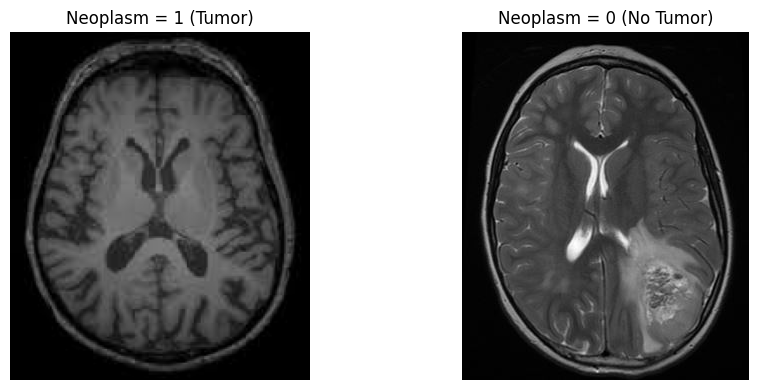

In [39]:
# Filter datasets
tumor_ds = ds['train'].filter(lambda x: x['neoplasm'] == 1)
non_tumor_ds = ds['train'].filter(lambda x: x['neoplasm'] == 0)

# Plot
if len(tumor_ds) > 0 and len(non_tumor_ds) > 0:
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(tumor_ds[0]['image'])
    plt.title("Neoplasm = 1 (Tumor)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(non_tumor_ds[0]['image'])
    plt.title("Neoplasm = 0 (No Tumor)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No data to display.")


# Section 4: Data Cleaning and Validation

In [40]:
# Store image shape stats
shape_counts = defaultdict(int)
mode_counts = defaultdict(int)

for item in ds['train']:
    img = item['image']
    shape_counts[img.size] += 1
    mode_counts[img.mode] += 1

print("Unique Image Sizes:")
for shape, count in shape_counts.items():
    print(f"  Size {shape}: {count} images")

print("\nImage Color Modes:")
for mode, count in mode_counts.items():
    print(f"  Mode {mode}: {count} images")


Unique Image Sizes:
  Size (173, 201): 4 images
  Size (630, 630): 20 images
  Size (300, 168): 6 images
  Size (225, 225): 36 images
  Size (750, 750): 2 images
  Size (275, 183): 2 images
  Size (232, 217): 6 images
  Size (220, 275): 4 images
  Size (442, 442): 8 images
  Size (214, 236): 2 images
  Size (504, 540): 2 images
  Size (642, 361): 2 images
  Size (420, 280): 2 images
  Size (400, 442): 2 images
  Size (206, 244): 4 images
  Size (275, 301): 2 images
  Size (550, 664): 2 images
  Size (728, 725): 2 images
  Size (409, 442): 2 images
  Size (512, 512): 8 images
  Size (177, 197): 2 images
  Size (218, 231): 4 images
  Size (228, 221): 4 images
  Size (200, 200): 2 images
  Size (194, 259): 2 images
  Size (207, 243): 2 images
  Size (208, 242): 4 images
  Size (235, 214): 2 images
  Size (200, 252): 4 images
  Size (201, 251): 10 images
  Size (215, 234): 2 images
  Size (630, 614): 2 images
  Size (212, 238): 2 images
  Size (350, 393): 2 images
  Size (230, 282): 2 imag

In [41]:
def preprocess_image(example, target_size=(224, 224)):
    try:
        img = example['image'].resize(target_size).convert('RGB')
        example['image'] = img
    except Exception as e:
        print("Failed to process:", example['umie_id'])
    return example

ds = ds.map(lambda x: preprocess_image(x, target_size=(224, 224)))


In [42]:
shapes_after = defaultdict(int)
for item in ds['train']:
    shapes_after[item['image'].size] += 1

print("Shapes after resizing:")
for s, count in shapes_after.items():
    print(f"  {s}: {count} images")


Shapes after resizing:
  (224, 224): 502 images


#Section 5: Exploratory Data Analysis (EDA)

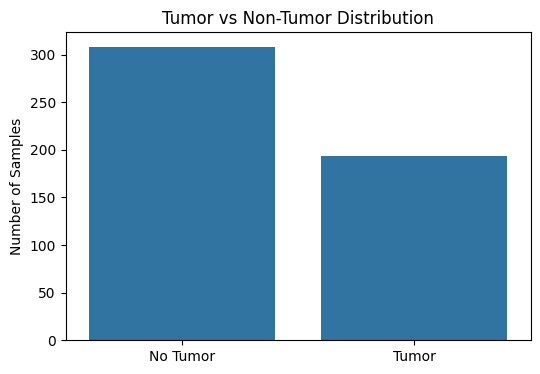

In [43]:

label_counts = Counter(ds['train']['neoplasm'])

plt.figure(figsize=(6, 4))
sns.barplot(x=['No Tumor', 'Tumor'], y=[label_counts[0], label_counts[1]])
plt.title("Tumor vs Non-Tumor Distribution")
plt.ylabel("Number of Samples")
plt.show()


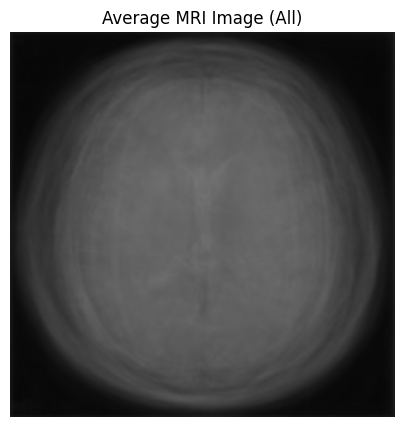

In [44]:
# Convert images to arrays and normalize
images_np = [np.array(img) / 255.0 for img in ds['train']['image']]
avg_image = np.mean(images_np, axis=0)

plt.figure(figsize=(5, 5))
plt.imshow(avg_image)
plt.title("Average MRI Image (All)")
plt.axis('off')
plt.show()



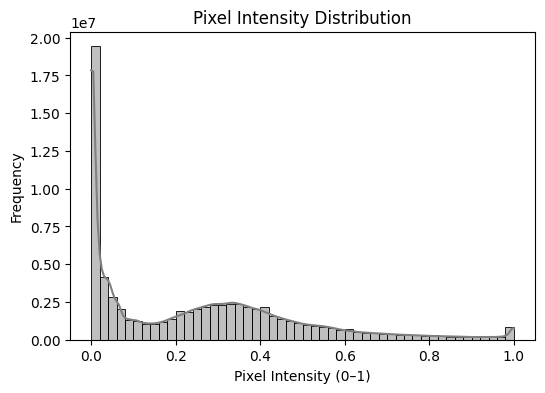

In [45]:
flat_pixels = np.array(images_np).flatten()

plt.figure(figsize=(6, 4))
sns.histplot(flat_pixels, bins=50, kde=True, color='gray')
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Intensity (0–1)")
plt.ylabel("Frequency")
plt.show()


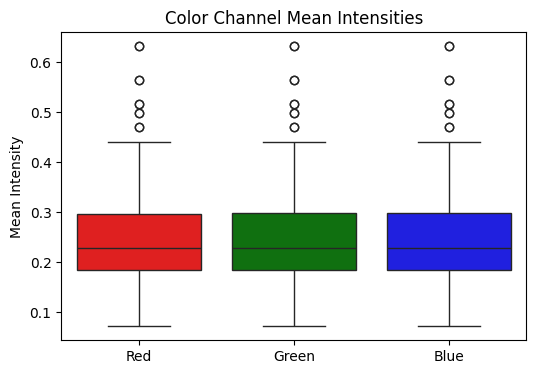

In [46]:
r_means, g_means, b_means = [], [], []

for img in images_np:
    r_means.append(img[:, :, 0].mean())
    g_means.append(img[:, :, 1].mean())
    b_means.append(img[:, :, 2].mean())

plt.figure(figsize=(6, 4))
sns.boxplot(data=[r_means, g_means, b_means], palette=['red', 'green', 'blue'])
plt.xticks([0, 1, 2], ['Red', 'Green', 'Blue'])
plt.title("Color Channel Mean Intensities")
plt.ylabel("Mean Intensity")
plt.show()


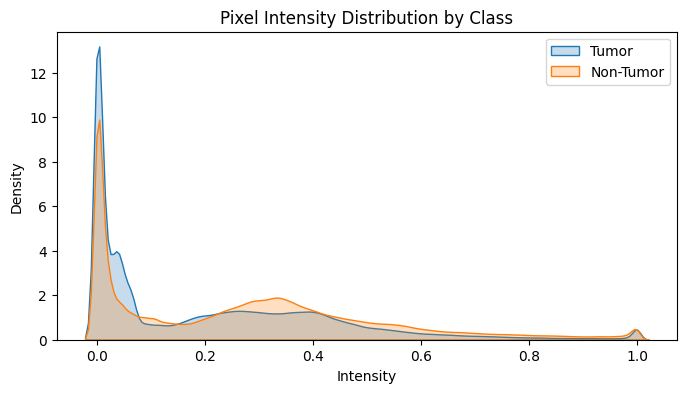

In [47]:
tumor_imgs = [np.array(x['image']) / 255.0 for x in ds['train'] if x['neoplasm'] == 1]
non_tumor_imgs = [np.array(x['image']) / 255.0 for x in ds['train'] if x['neoplasm'] == 0]

tumor_flat = np.array(tumor_imgs).flatten()
non_tumor_flat = np.array(non_tumor_imgs).flatten()

plt.figure(figsize=(8, 4))
sns.kdeplot(tumor_flat, label='Tumor', shade=True)
sns.kdeplot(non_tumor_flat, label='Non-Tumor', shade=True)
plt.title("Pixel Intensity Distribution by Class")
plt.xlabel("Intensity")
plt.legend()
plt.show()


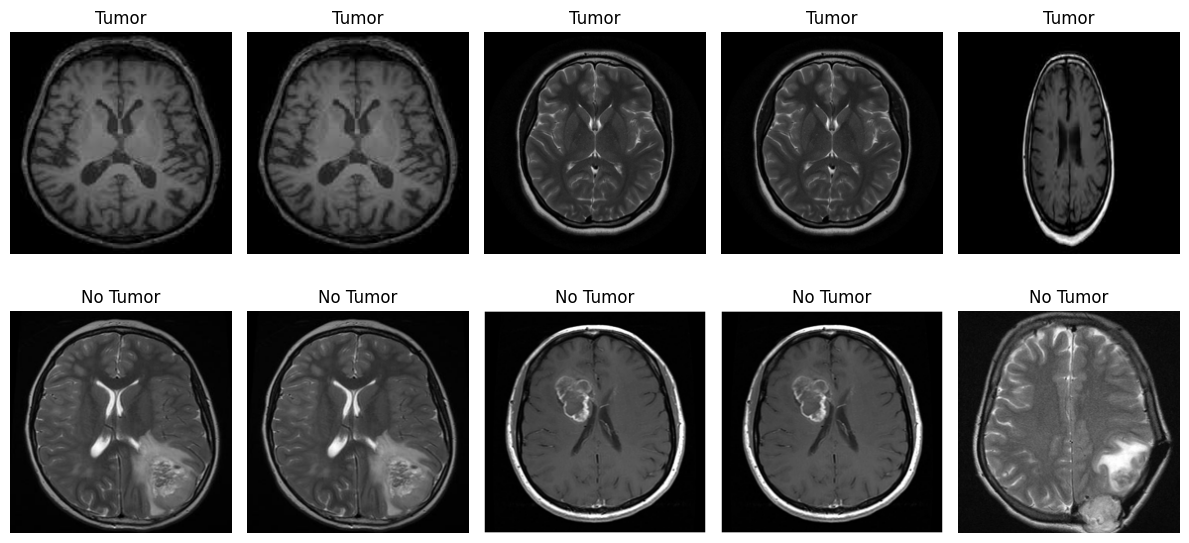

In [48]:
plt.figure(figsize=(12, 6))
tumor_samples = [x['image'] for x in ds['train'] if x['neoplasm'] == 1][:5]
non_tumor_samples = [x['image'] for x in ds['train'] if x['neoplasm'] == 0][:5]

for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(tumor_samples[i])
    plt.title("Tumor")
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(non_tumor_samples[i])
    plt.title("No Tumor")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Section 6: Preprocessing for Modeling

In [49]:
X = np.array([np.array(x['image']) / 255.0 for x in ds['train']]).astype(np.float32)
y = np.array([x['neoplasm'] for x in ds['train']])

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (502, 224, 224, 3)
y shape: (502,)


In [50]:
# Split into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


Train size: 401
Test size: 101


In [51]:
# Define dataset class
class BrainTumorDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]


        if self.transform:
            image = self.transform(image)
        else:
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)


        return image, torch.tensor(label).long()

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create PyTorch datasets
train_dataset = BrainTumorDataset(X_train, y_train, transform=transform)
test_dataset = BrainTumorDataset(X_test, y_test, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Section 7: Model Building and Training

In [52]:
class BrainTumorCNN(nn.Module):
    def __init__(self):
        super(BrainTumorCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 54 * 54, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 54 * 54)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [53]:
def build_resnet18():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 2)
    )
    return model


In [54]:
def build_mobilenetv2():
    model = models.mobilenet_v2(pretrained=True)
    for param in model.features.parameters():
        param.requires_grad = False
    model.classifier = nn.Sequential(
        nn.Linear(model.last_channel, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 2)
    )
    return model


In [55]:
# Training function
def train_model(model, model_name, train_loader, val_loader, num_epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print(f"\nTraining {model_name}")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {running_loss:.4f} - Accuracy: {accuracy:.2f}%")

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    print(f"Validation Accuracy for {model_name}: {val_acc:.2f}%")
    return val_acc

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

train_dataset = BrainTumorDataset(X_train, y_train, transform=transform)
val_dataset = BrainTumorDataset(X_val, y_val, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [57]:
# Instantiate and train each model
model1 = BrainTumorCNN()
model2 = build_resnet18()
model3 = build_mobilenetv2()

train_model(model1, "BrainTumorCNN", train_loader, val_loader)
train_model(model2, "ResNet18", train_loader, val_loader)
train_model(model3, "MobileNetV2", train_loader, val_loader)


Training BrainTumorCNN
Epoch [1/10] - Loss: 16.7463 - Accuracy: 63.34%
Epoch [2/10] - Loss: 5.7265 - Accuracy: 79.80%
Epoch [3/10] - Loss: 4.2514 - Accuracy: 87.28%
Epoch [4/10] - Loss: 2.0960 - Accuracy: 95.51%
Epoch [5/10] - Loss: 0.8242 - Accuracy: 98.75%
Epoch [6/10] - Loss: 0.3722 - Accuracy: 99.50%
Epoch [7/10] - Loss: 0.4002 - Accuracy: 99.50%
Epoch [8/10] - Loss: 0.2925 - Accuracy: 99.50%
Epoch [9/10] - Loss: 0.1150 - Accuracy: 100.00%
Epoch [10/10] - Loss: 0.0285 - Accuracy: 100.00%
Validation Accuracy for BrainTumorCNN: 98.02%

Training ResNet18
Epoch [1/10] - Loss: 7.6453 - Accuracy: 66.58%
Epoch [2/10] - Loss: 4.8871 - Accuracy: 84.79%
Epoch [3/10] - Loss: 5.2739 - Accuracy: 81.55%
Epoch [4/10] - Loss: 3.9676 - Accuracy: 89.03%
Epoch [5/10] - Loss: 3.4211 - Accuracy: 88.78%
Epoch [6/10] - Loss: 3.7252 - Accuracy: 85.29%
Epoch [7/10] - Loss: 2.6512 - Accuracy: 94.26%
Epoch [8/10] - Loss: 2.4591 - Accuracy: 93.77%
Epoch [9/10] - Loss: 2.3591 - Accuracy: 93.02%
Epoch [10/10] 

86.13861386138613

# Section 8: Model Evaluation and Comparison

In [58]:
def get_model_metrics(model, test_loader, model_name):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    metrics = {
        "Model": model_name,
        "Accuracy": accuracy_score(all_labels, all_preds),
        "Precision": precision_score(all_labels, all_preds),
        "Recall": recall_score(all_labels, all_preds),
        "F1-Score": f1_score(all_labels, all_preds),
        "Confusion Matrix": confusion_matrix(all_labels, all_preds)
    }

    return metrics


In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

metrics_list = [
    get_model_metrics(model1, test_loader, "BrainTumorCNN"),
    get_model_metrics(model2, test_loader, "ResNet18"),
    get_model_metrics(model3, test_loader, "MobileNetV2")
]

<Figure size 1000x600 with 0 Axes>

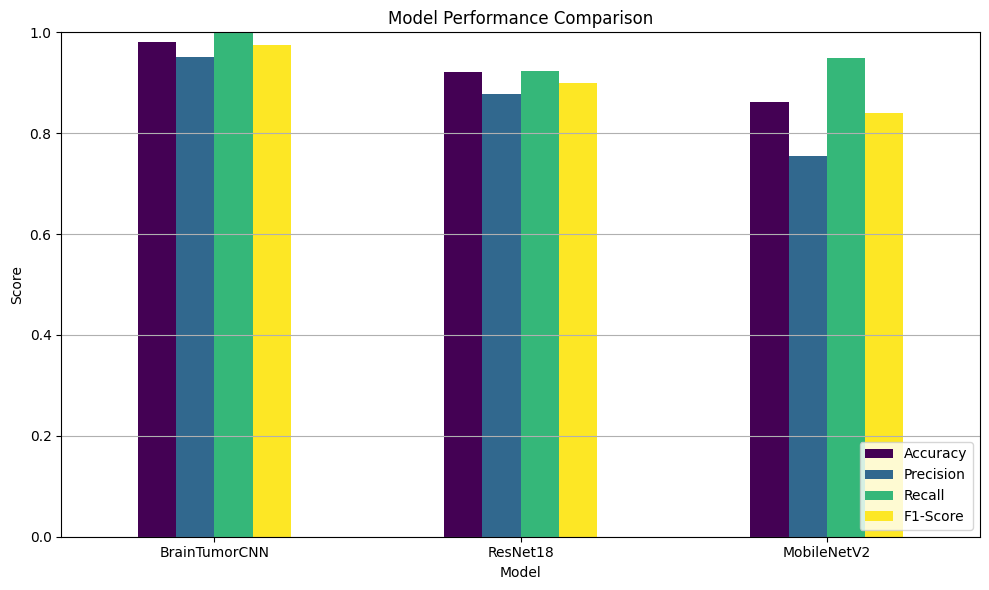

In [60]:
# Convert to DataFrame
df_metrics = pd.DataFrame(metrics_list).drop(columns="Confusion Matrix")

# Plot metrics comparison
plt.figure(figsize=(10, 6))
df_metrics.set_index("Model").plot(kind="bar", ylim=(0, 1), figsize=(10, 6), colormap="viridis")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


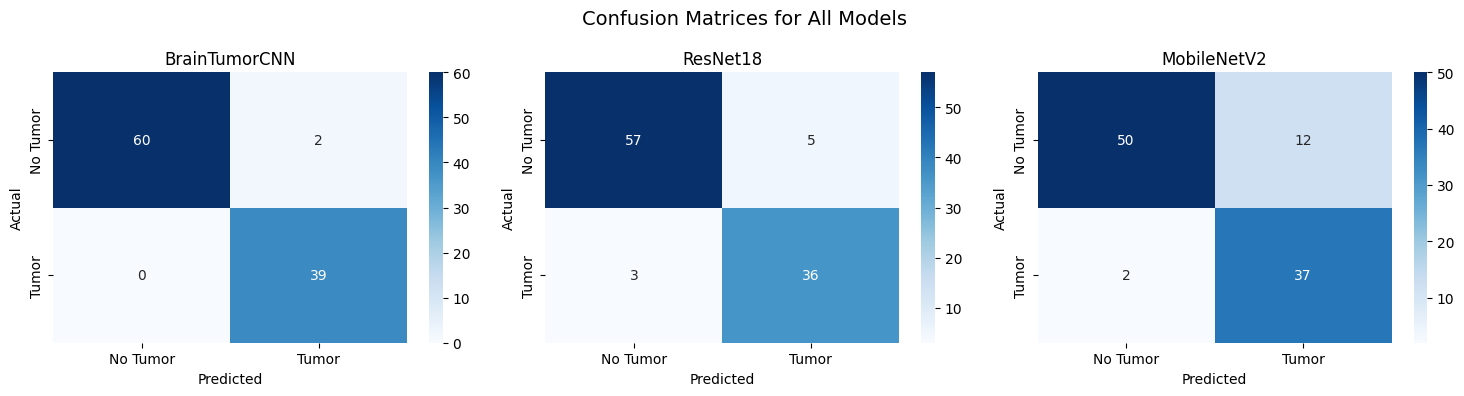

In [61]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, m in enumerate(metrics_list):
    sns.heatmap(
        m["Confusion Matrix"],
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=axes[idx],
        xticklabels=["No Tumor", "Tumor"],
        yticklabels=["No Tumor", "Tumor"]
    )
    axes[idx].set_title(m["Model"])
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")

plt.suptitle("Confusion Matrices for All Models", fontsize=14)
plt.tight_layout()
plt.show()


In [62]:
from sklearn.metrics import roc_curve, auc

def compute_roc(model, loader, model_name, device):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    return {"model_name": model_name, "fpr": fpr, "tpr": tpr, "roc_auc": roc_auc}

def plot_roc_curves(roc_data):
    plt.figure(figsize=(8, 6))
    for data in roc_data:
        plt.plot(data["fpr"], data["tpr"], label=f'{data["model_name"]} (AUC = {data["roc_auc"]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.50)')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves for Models")
    plt.legend()
    plt.grid(True)
    plt.show()

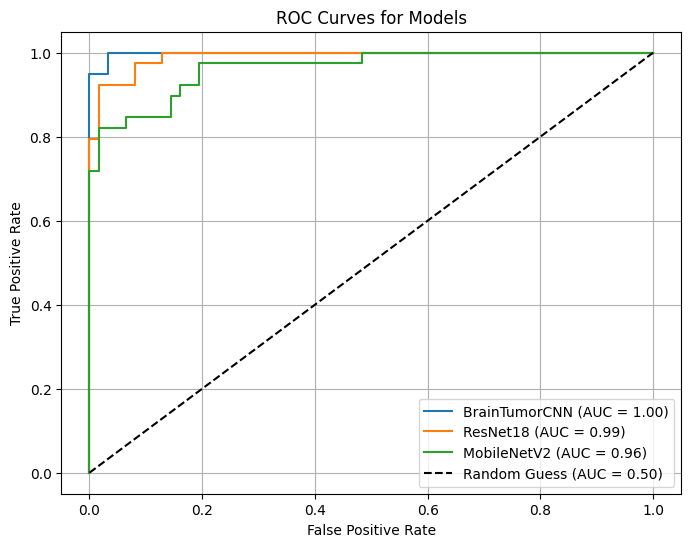

In [63]:
# Get ROC data for each model
roc_data = []
roc_data.append(compute_roc(model1, test_loader, "BrainTumorCNN", device))
roc_data.append(compute_roc(model2, test_loader, "ResNet18", device))
roc_data.append(compute_roc(model3, test_loader, "MobileNetV2", device))

# Plot the ROC curves
plot_roc_curves(roc_data)

#  Section 9: Model Saving and Export

In [64]:
# Save each model
torch.save(model1.state_dict(), "BrainTumorCNN.pth")
torch.save(model2.state_dict(), "ResNet18.pth")
torch.save(model3.state_dict(), "MobileNetV2.pth")


In [65]:
# Load custom CNN
model1 = BrainTumorCNN()
model1.load_state_dict(torch.load("BrainTumorCNN.pth"))
model1.eval()

# Load ResNet
model2 = build_resnet18()
model2.load_state_dict(torch.load("ResNet18.pth"))
model2.eval()

# Load MobileNet
model3 = build_mobilenetv2()
model3.load_state_dict(torch.load("MobileNetV2.pth"))
model3.eval()


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

# Section 10: SHAP Explainability


=== Generating SHAP for BrainTumorCNN ===
Plotting SHAP values for BrainTumorCNN...


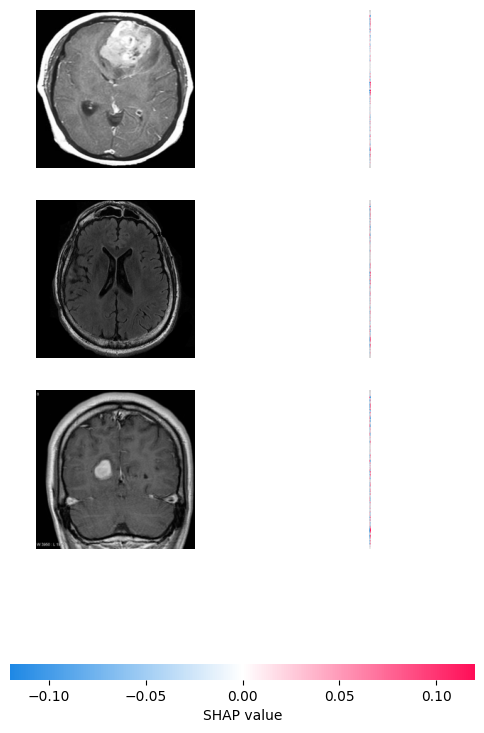


=== Generating SHAP for ResNet18 ===
Plotting SHAP values for ResNet18...


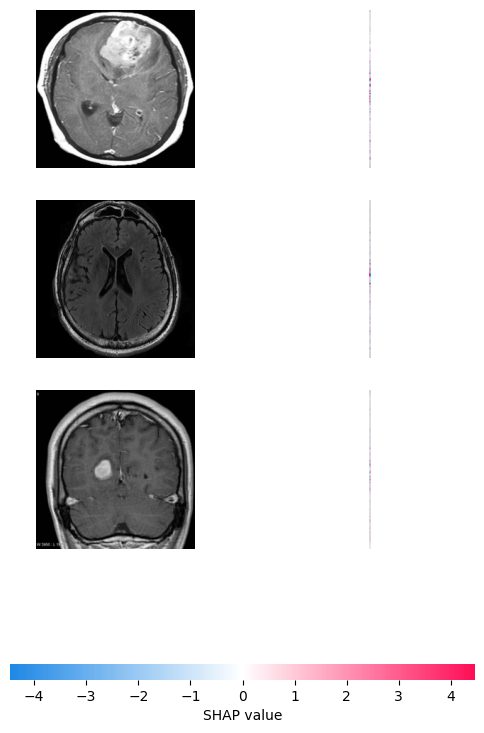


=== Generating SHAP for MobileNetV2 ===
Plotting SHAP values for MobileNetV2...


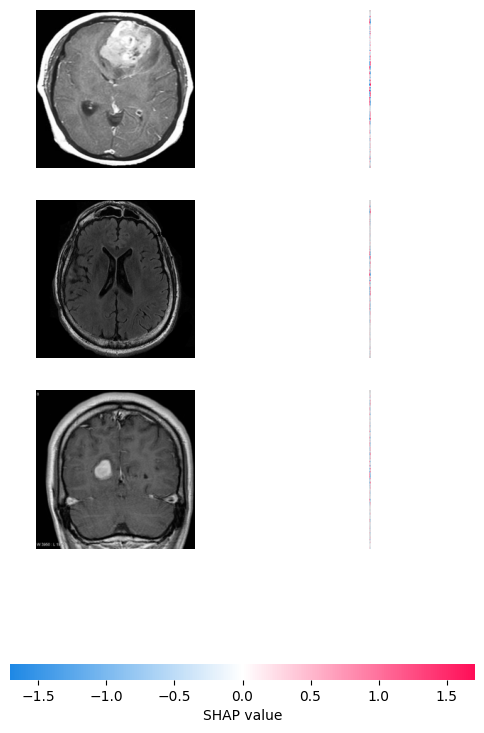

In [66]:
import shap

# Choose device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trained_models = {
    "BrainTumorCNN": model1,
    "ResNet18": model2,
    "MobileNetV2": model3
}

background_images, _ = next(iter(test_loader))
background_images = background_images[:10].to(device)

test_images, _ = next(iter(test_loader))
test_images_sample = test_images[:3].to(device)
test_images_np = test_images[:3].numpy()

for model_name, model in trained_models.items():
    print(f"\n=== Generating SHAP for {model_name} ===")
    model.to(device)
    model.eval()

    explainer = shap.GradientExplainer(model, background_images)

    # Compute SHAP values
    shap_values = explainer.shap_values(test_images_sample)

    shap_values_tumor = shap_values[1]
    shap_values_tumor_reshaped = shap_values_tumor.transpose(0, 2, 3, 1)

    print(f"Plotting SHAP values for {model_name}...")
    shap.image_plot(
        shap_values_tumor_reshaped,
        test_images_np.transpose(0, 2, 3, 1),
        show=True
    )
